# RealNVP

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**
- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184?keywords=generative+deep+learning,+2nd+edition&qid=1684708209&sprefix=generative+de,aps,93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/06_normflow/01_realnvp/realnvp.ipynb)

In [1]:
import time
from IPython import display

import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as sk_datasets

import torch
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader

import torchinfo

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("device: ", DEVICE)

device:  cuda


## 0. Training Parameters

In [2]:
NUM_SAMPLES = 30_000
COULPING_LAYERS = 6
INPUT_DIM = 2
HIDDEN_DIM = 256
REGULARIZATION = 1e-3
BATCH_SIZE = 256
EPOCHS = 100

## 1. Preparing Moon dataset

The shape of moon dataset (30000, 2)


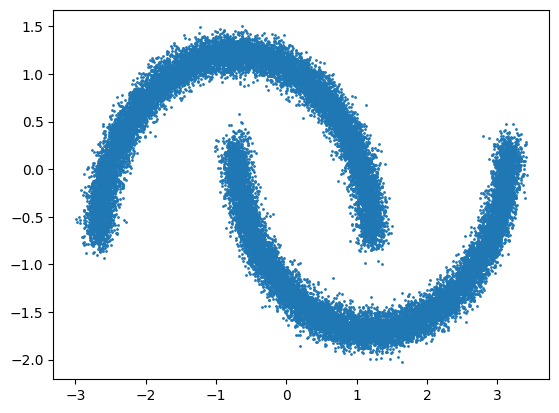

In [3]:
data = sk_datasets.make_moons(NUM_SAMPLES, noise=5e-2)[0].astype("float32")
print("The shape of moon dataset", data.shape)
# data normalization
mean = data.mean()
std = data.std()
moon_data = (data - mean) / (std ** 2)
# visualize data
plt.scatter(moon_data[:, 0], moon_data[:, 1], s=1.0)
plt.show()

## 2. Building RealNVP

Building backbone layer

In [4]:
def get_backbone_layer(n_layers=5, output_activation=nn.Tanh):
    dims = [INPUT_DIM] + [HIDDEN_DIM] * (n_layers - 1) + [INPUT_DIM]
    layers = []
    for i in range(n_layers):
        layers.append(nn.Linear(dims[i], dims[i+1]))
        if i != n_layers - 1: 
            layers.append(nn.ReLU())
        else:
            layers.append(output_activation())
    return nn.Sequential(*layers)

In [5]:
torchinfo.summary(get_backbone_layer(), input=(1, 2))

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            768
├─ReLU: 1-2                              --
├─Linear: 1-3                            65,792
├─ReLU: 1-4                              --
├─Linear: 1-5                            65,792
├─ReLU: 1-6                              --
├─Linear: 1-7                            65,792
├─ReLU: 1-8                              --
├─Linear: 1-9                            514
├─Tanh: 1-10                             --
Total params: 198,658
Trainable params: 198,658
Non-trainable params: 0

Implement RealNVP model

In [6]:
class RealNVP(nn.Module):

    num_couplings = COULPING_LAYERS
    device = DEVICE
    
    def __init__(self):
        super().__init__()
        # Create multivariate normal distribution
        loc = torch.zeros(2, device=self.device, requires_grad=False)
        cov = torch.eye(2, device=self.device, requires_grad=False)
        self.distribution = distributions.MultivariateNormal(loc = loc, 
                                                             covariance_matrix = cov)
        
        mask = torch.tensor([[0, 1], [1, 0]] * (self.num_couplings // 2), dtype=torch.float32)
        self.register_buffer("mask", mask)
        
        self.t = nn.ModuleList([get_backbone_layer(output_activation=nn.Identity)
                                for _ in range(self.num_couplings)])
        self.s = nn.ModuleList([get_backbone_layer(output_activation=nn.Tanh)
                                for _ in range(self.num_couplings)])


    # f(x) forward process
    def f(self, x):
        log_det_inv = x.new_zeros(x.shape[0])
        z = x
        for i in reversed(range(len(self.t))):
            z_masked = self.mask[i] * z
            s = self.s[i](z_masked) * (1 - self.mask[i])
            t = self.t[i](z_masked) * (1 - self.mask[i])
            z = z_masked + (1 - self.mask[i]) * (z - t) * torch.exp(-s)
            log_det_inv -= s.sum(dim=1)
        return z, log_det_inv

    
    # g(z) backward process
    @torch.no_grad()
    def g(self, z):
        x = z
        for i in range(len(self.s)):
            x_masked = self.mask[i] * x
            s = self.s[i](x_masked) * (1 - self.mask[i])
            t = self.t[i](x_masked) * (1 - self.mask[i])
            x = x_masked + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    # forward process
    def forward(self, data=None, num_samples=None, forward=True):
        if forward:
            assert data is not None, "Training data should be provided" 
            z, log_det = self.f(data)
            return z, log_det
        else:
            assert num_samples is not None, "Number of samples should be provided"
            samples = self.distribution.sample((num_samples,))
            x = self.g(samples)
            return samples, x

In [7]:
torchinfo.summary(RealNVP(), input=(1, 2), depth=2)

Layer (type:depth-idx)                   Param #
RealNVP                                  --
├─ModuleList: 1-1                        --
│    └─Sequential: 2-1                   198,658
│    └─Sequential: 2-2                   198,658
│    └─Sequential: 2-3                   198,658
│    └─Sequential: 2-4                   198,658
│    └─Sequential: 2-5                   198,658
│    └─Sequential: 2-6                   198,658
├─ModuleList: 1-2                        --
│    └─Sequential: 2-7                   198,658
│    └─Sequential: 2-8                   198,658
│    └─Sequential: 2-9                   198,658
│    └─Sequential: 2-10                  198,658
│    └─Sequential: 2-11                  198,658
│    └─Sequential: 2-12                  198,658
Total params: 2,383,896
Trainable params: 2,383,896
Non-trainable params: 0

## 3. Defining Trainstep functions

In [8]:
def train_step(model, dataloader, optim):
    model.train()
    train_loss = 0
    assert model.training, "Model should be in the training mode, set 'model.train()'"

    for data in dataloader:
        data = data.to(DEVICE)
        optim.zero_grad()
        z, log_det = model(data)
        log_prob = model.distribution.log_prob(z) + log_det
        loss = -log_prob.mean() # Maximize log prob
        loss.backward()
        optim.step()
        train_loss += loss.item()
    
    return train_loss / len(dataloader)


def show_distribution(moon_data, model):
    num_test_sample = 3000
    model.eval()
    normalized_moon = moon_data[:num_test_sample]
    samples = torch.from_numpy(normalized_moon).to(DEVICE)
    zs, _ = model(data=samples, forward=True)
    samples, xs = model(num_samples=num_test_sample, forward=False)

    plt.figure(figsize=(12, 3))
    # 1. Plot moon data
    ax = plt.subplot(1, 4, 1)
    ax.scatter(normalized_moon[:, 0], normalized_moon[:, 1], c="tomato", s=1)
    ax.set_title("data")

    # 2. Plot forward process result
    zs = zs.detach().cpu().numpy()
    ax = plt.subplot(1, 4, 2)
    ax.scatter(zs[:, 0], zs[:, 1], c="tomato", s=1)
    ax.set_title("$z = f(x)$")
    
    # 3. Plot samples from distribution
    samples = samples.detach().cpu().numpy()
    ax = plt.subplot(1, 4, 3)
    ax.scatter(samples[:, 0], samples[:, 1], c="steelblue", s=1)
    ax.set_title("samples")

    # 4. Plot backward process result
    xs = xs.detach().cpu().numpy()
    ax = plt.subplot(1, 4, 4)
    ax.scatter(xs[:, 0], xs[:, 1], c="steelblue", s=1)
    ax.set_title("$x = g(z)$")
    
    plt.show()

## 4. Define the model, dataloader, and optimizer

In [9]:
# model
real_nvp = RealNVP().to(DEVICE)

if torch.__version__.split('.')[0] == '2':
    torch.set_float32_matmul_precision('high')
    # It is important to use eager backend here to avoid
    # distribution mismatch in training and predicting
    real_nvp = torch.compile(real_nvp)
    print('model compiled')

# creating dataloader
moon_loader = DataLoader(dataset=moon_data, batch_size=BATCH_SIZE, shuffle=True)

# optimizer
optim = torch.optim.Adam(real_nvp.parameters(), lr=1e-4, weight_decay=REGULARIZATION)

model compiled


## 5. Training

Epoch 100	Time:0.03 min
	Train loss: 1.6957


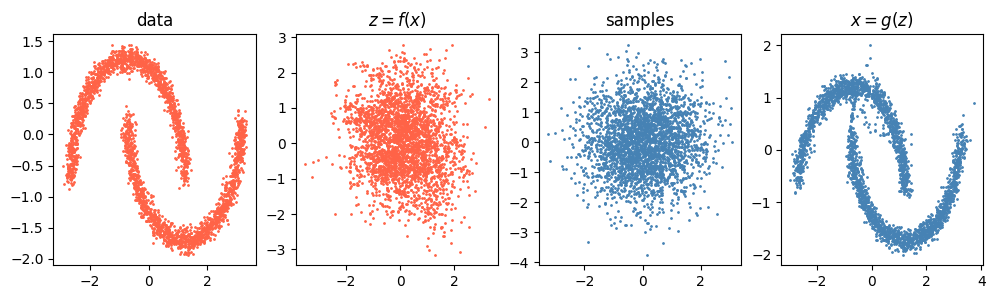

Process ForkProcess-31:
Process ForkProcess-15:
Process ForkProcess-29:
Process ForkProcess-16:
Process ForkProcess-23:
Process ForkProcess-19:
Process ForkProcess-2:
Process ForkProcess-20:
Process ForkProcess-22:
Process ForkProcess-28:
Process ForkProcess-32:
Process ForkProcess-17:
Process ForkProcess-9:
Process ForkProcess-25:
Process ForkProcess-18:
Process ForkProcess-24:
Process ForkProcess-30:
Process ForkProcess-4:
Process ForkProcess-26:
Process ForkProcess-3:
Process ForkProcess-14:
Process ForkProcess-7:
Process ForkProcess-21:
Process ForkProcess-5:
Process ForkProcess-27:
Process ForkProcess-1:
Process ForkProcess-6:
Process ForkProcess-10:
Process ForkProcess-8:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last)

In [10]:
loss_hist = np.zeros(shape=(EPOCHS,))
for i in range(EPOCHS):
    prev_time = time.time()
    train_loss = train_step(real_nvp, moon_loader, optim)
    loss_hist[i] = train_loss
    curr_time = time.time()
    if i == 0 or (i + 1) % 20 == 0:
        display.clear_output(wait=True)
        print(f'Epoch {i+1:3d}\tTime:{(curr_time - prev_time) / 60:.2f} min')
        print(f'\tTrain loss: {train_loss:.4f}')
        show_distribution(moon_data, real_nvp)

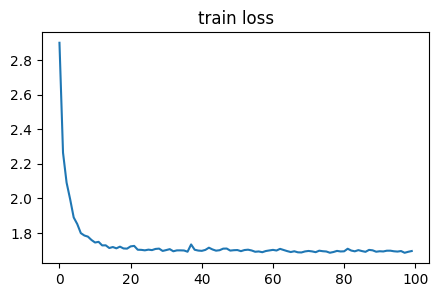

In [11]:
plt.figure(figsize=(5, 3))
plt.plot(loss_hist)
plt.title("train loss")
plt.show()

## 6. Check result

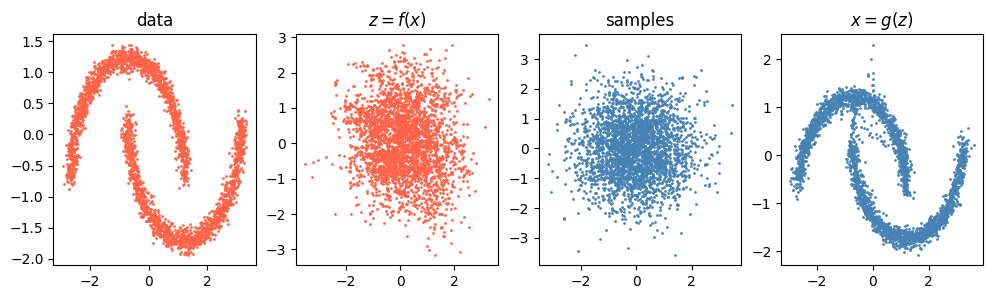

In [12]:
show_distribution(moon_data, real_nvp)